This notebook can plot hardening plots and also try to determine the critical strains for dynamic recrystallization.

For the critical strain for DRX, it uses the method outlined in Jonas et al. ISIJ International, Vol. 43 (2003), No. 5, pp. 684–691

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as PyPlot
import os
import glob
import re
from scipy.interpolate import UnivariateSpline
from numpy.polynomial import Polynomial
%matplotlib inline

In [2]:
df = pd.read_excel('Data/06_FullStressStrain_Ni30Fe_900C-1s-1.xlsx',header=4,usecols='A:L',engine='openpyxl')

In [3]:
expt_data_dict = {}

In [4]:
T_string = re.compile('[0-9]+C')
eps_dot_string = re.compile('[0-9]+s-1')

In [5]:
for i in os.listdir('Data/'):
    df = pd.read_excel('Data/' + i,header=4,usecols='A:L',engine='openpyxl')
    expt_data_dict[i] = df

In [6]:
expt_data_dict.keys()

dict_keys(['06_FullStressStrain_Ni30Fe_900C-1s-1.xlsx', '01_FullStressStrain_Ni30Fe_1000C-1s-1.xlsx', '02_FullStressStrain_Ni30Fe_1000C-01s-1.xlsx', '03_FullStressStrain_Ni30Fe_1000C-001s-1.xlsx', '04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx'])

In [7]:
max_stress_lim = 0.0
max_strain_lim = 0.0
for expt_data in expt_data_dict.values():
    max_y_lim = np.max(expt_data['True Stress'])   #finding maximum stress for a given file
    max_x_lim = np.max(expt_data['True Strain'])   #finding maximum strain for a given file
    if max_y_lim > max_stress_lim:
        max_stress_lim = max_y_lim
    if max_x_lim > max_strain_lim:
        max_strain_lim = max_x_lim

Rounding off the values

In [8]:
max_strain_lim = round(max_strain_lim * 2.0) / 2.0
max_stress_lim = (round(max_stress_lim/50.0)+2.0)*50.0

## Plot settings

In [9]:
set_colors = ['black','red','teal','fuchsia','blue'] # https://matplotlib.org/gallery/color/named_colors.html

In [10]:
# might remove it if it is too much
#PyPlot.rcParams["text.usetex"] =True  
#using latex rendering https://stackoverflow.com/questions/43741928/matplotlib-raw-latex-epsilon-only-yields-varepsilon

In [11]:
linestyle_list = ['solid', 'dashed', 'dashdot', 'dotted','solid']
label_list = [1073,1173,1273,1373]

### Plotting stress strain curves

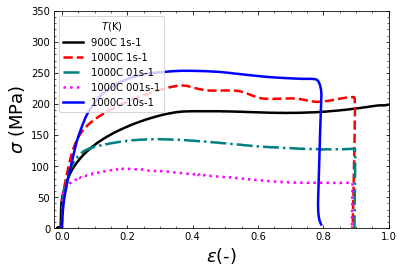

In [12]:
fig, ax = PyPlot.subplots()
ax.tick_params(which='both',direction="in",top=True,right=True)
ax.minorticks_on()

for key,line,colors in zip(expt_data_dict.keys(),linestyle_list,set_colors):
    PyPlot.plot(expt_data_dict[key]['True Strain'],
                expt_data_dict[key]['True Stress'],
                color=colors,
                linewidth = 2.5,
                linestyle = line,
                label = '{} {}'.format(T_string.findall(key)[0],eps_dot_string.findall(key)[0])
                )
    PyPlot.xlim(-0.025,max_strain_lim)
    PyPlot.ylim(0.0,max_stress_lim)
    PyPlot.xlabel(r'$\epsilon$(-)',fontsize=18)   # latex based symbols
    PyPlot.ylabel(r'$\sigma$ (MPa)',fontsize=18)
    PyPlot.legend(title=r'$ T (\mathrm{K})$')#,title_fontsize ='large')
        
# fig.savefig('multi_stress_strain.png',dpi=600)

## Plotting hardening curves

Check if data is monotonically increasing

Restrict data to the interesting region

Defining a function to make data monotonic

In [158]:
def to_monotonic_inc(s):
    return s[s >= s.cummax()]

In [159]:
expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx'] = \
                                                      expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx']\
                                                      [(expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx']\
                                                        ['True Strain'] < 0.025)]

In [160]:
expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx']['True Stress'].is_monotonic_increasing

False

In [161]:
expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx']['True Strain'].is_monotonic_increasing

False

In [162]:
indices_for_monotonic = \
to_monotonic_inc(expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx']['True Strain']).index

In [163]:
monotonic_expt = {}

In [164]:
df = pd.DataFrame({'True Strain': \
                   expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx']['True Strain'][indices_for_monotonic],
                   'True Stress': \
                   expt_data_dict['04_FullStressStrain_Ni30Fe_1000C-10s-1.xlsx']['True Stress'][indices_for_monotonic]})

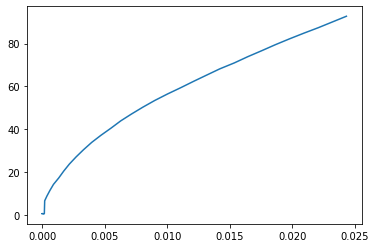

In [165]:
PyPlot.plot(df['True Strain'],df['True Stress'])

#### Fit a ploynomial for smoother behaviour

In [166]:
f = UnivariateSpline(df['True Strain'],df['True Stress'],k=3,s=0)
xnew = np.linspace(0.0,np.max(df['True Strain']),500)

In [188]:
c1 = Polynomial.fit(xnew,f(xnew),9)
xnew1,fitted1 = c1.linspace()
df_fit = pd.DataFrame({'True Strain':xnew1,'True Stress':fitted1})

In [189]:
indices_for_monotonic = \
to_monotonic_inc(df_fit['True Stress']).index

In [190]:
df_fit = pd.DataFrame({'True Strain': \
                   xnew1[indices_for_monotonic],
                   'True Stress': \
                   fitted1[indices_for_monotonic]})

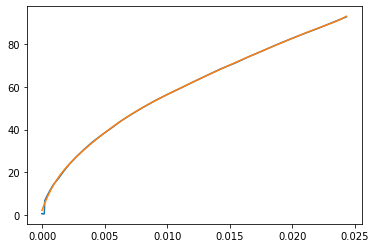

In [191]:
PyPlot.plot(df['True Strain'],df['True Stress'])
# PyPlot.plot(xnew,f(xnew))
# PyPlot.plot(xnew1,fitted1)
PyPlot.plot(df_fit['True Strain'],df_fit['True Stress'])

In [192]:
hardening_rate = np.diff(df['True Stress'])/np.diff(df['True Strain'])

In [193]:
hardening_rate_smooth = np.diff(df_fit['True Stress'])/np.diff(df_fit['True Strain'])

(0.0, 5000.0)

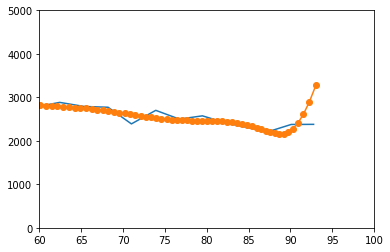

In [194]:
PyPlot.plot(df['True Stress'][1:],hardening_rate)
PyPlot.plot(df_fit['True Stress'][1:],hardening_rate_smooth,marker='o')
PyPlot.xlim(60.0,100.0)
PyPlot.ylim(0.0,5000.0)

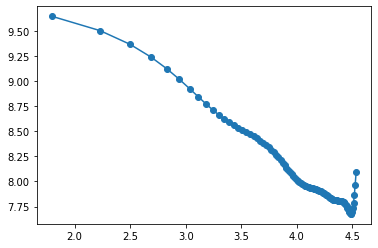

In [195]:
PyPlot.plot(np.log(df_fit['True Stress'][1:]),np.log(hardening_rate_smooth),marker='o')
# PyPlot.xlim(150.0,250.0)
# PyPlot.ylim(0.0,1000.0)

#### Derivative of the hardening rate to find the cusp

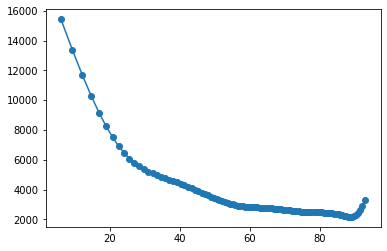

In [196]:
PyPlot.plot(df_fit['True Stress'][1:],hardening_rate_smooth,marker='o')

In [197]:
f2 = UnivariateSpline(df_fit['True Stress'][1:],hardening_rate_smooth,k=3,s=0)
xnew2 = np.linspace(0.0,np.max(fitted1[1:]),200)

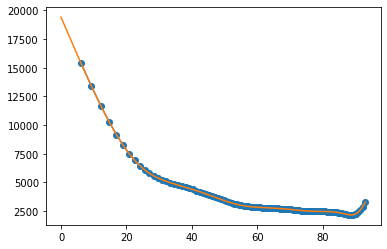

In [198]:
PyPlot.plot(df_fit['True Stress'][1:],hardening_rate_smooth,marker='o')
PyPlot.plot(xnew2,f2(xnew2))#,marker='o')

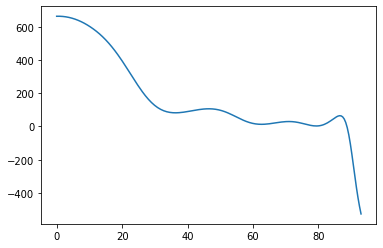

In [199]:
PyPlot.plot(xnew2,-f2.derivative()(xnew2))